In [ ]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential, load_model, save_model
import seaborn as sns
from pylab import rcParams
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%matplotlib inline
sns.set(style = 'whitegrid', palette = 'muted', font_scale = 1.5)
rcParams['figure.figsize'] = 14, 8
random_seed = 42

In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.4 MB 7.6 MB/s 
     |████████████████████████████████| 62 kB 1.7 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.28.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import yfinance as yf
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.tsa.api as smt

In [ ]:
bajaj = yf.download('BAJAJ-AUTO.NS', start = '2003-01-01', end = '2022-07-06', progress = False)

In [ ]:
bajaj.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-06-29,3880.000000,3900.000000,3856.050049,3867.550049,3727.550049,524392
2022-06-30,3750.000000,3768.350098,3692.000000,3706.600098,3706.600098,715926
2022-07-01,3667.949951,3678.699951,3601.100098,3624.600098,3624.600098,756589
2022-07-04,3644.399902,3695.149902,3608.000000,3679.750000,3679.750000,536505
2022-07-05,3700.000000,3700.000000,3663.000000,3682.750000,3682.750000,294980


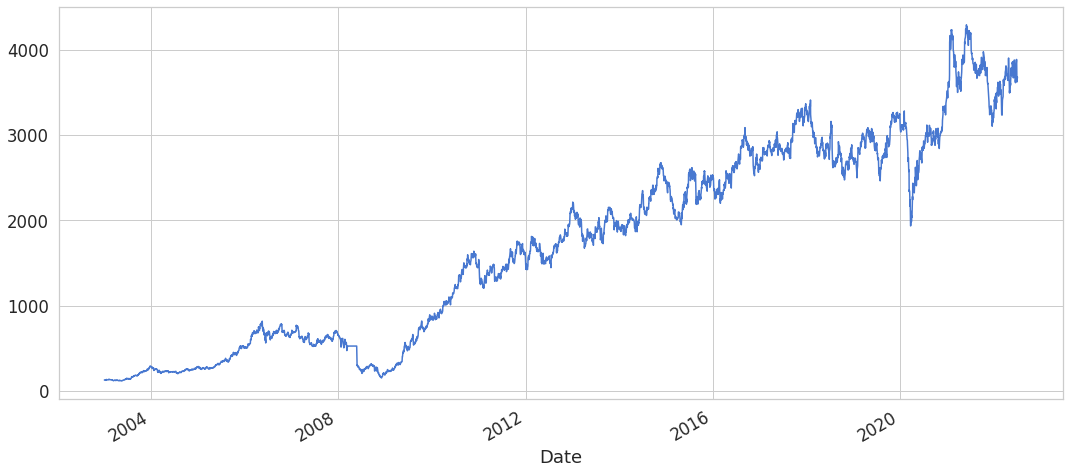

In [ ]:
bajaj['Close'].plot(figsize = (18, 8))

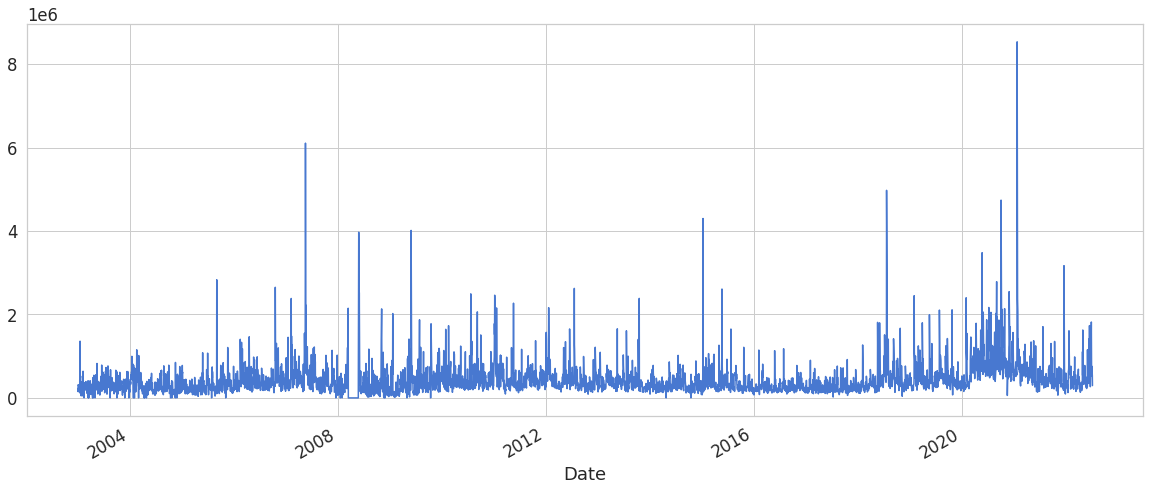

In [ ]:
bajaj['Volume'].plot(figsize = (20, 8))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5a3c684d90>,
      dtype=object)

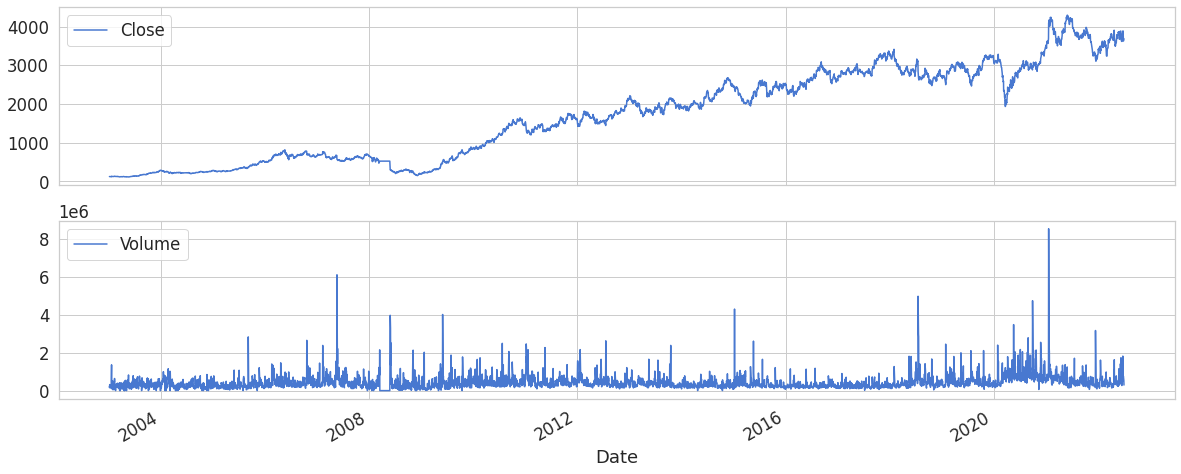

In [ ]:
bajaj[['Close', 'Volume']].plot(subplots = True, style = 'b', figsize = (20, 8))

In [ ]:
bajaj.describe()

,Open,High,Low,Close,Adj Close,Volume
count,4844.000000,4844.000000,4844.000000,4844.000000,4844.000000,4.844000e+03
mean,1712.169786,1733.816688,1689.537677,1710.973372,1429.135761,4.263822e+05
std,1162.127924,1174.013617,1149.720648,1161.014702,1086.652942,3.853127e+05
min,117.237503,117.962502,103.862503,116.224998,77.551155,0.000000e+00
25%,568.687500,583.500000,552.750000,569.509399,383.001251,2.232635e+05
50%,1735.525024,1757.625000,1712.200012,1738.224976,1313.348511,3.345555e+05
75%,2745.462524,2775.700073,2714.362427,2740.750000,2358.292358,5.120660e+05
max,4294.299805,4361.399902,4242.000000,4295.049805,4001.201904,8.537143e+06


**pct_change - Percentage Change between current and prior element**

In [ ]:
bajaj['simple_rtn'] = bajaj.Close.pct_change()
bajaj['log_rtn'] = np.log(bajaj.Close / bajaj.Close.shift(1))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5a3f07ac10>,
      dtype=object)

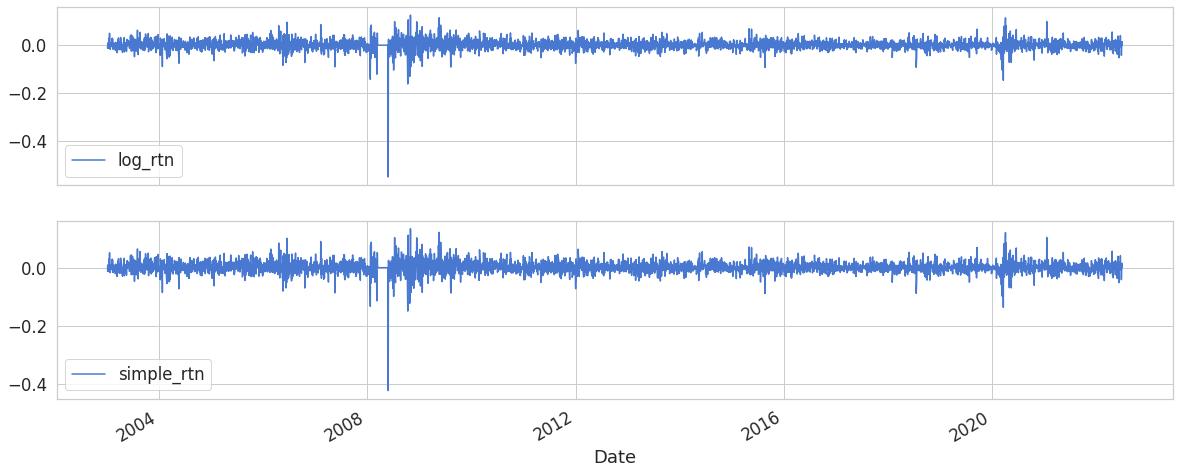

In [ ]:
bajaj[['log_rtn', 'simple_rtn']].plot(subplots = True, style = 'b', figsize = (20, 8))

In [ ]:
bajaj[['simple_rtn', 'log_rtn']].tail()

,simple_rtn,log_rtn
Date,,
2022-06-29,-0.005516,-0.005531
2022-06-30,-0.041615,-0.042506
2022-07-01,-0.022123,-0.022371
2022-07-04,0.015215,0.015101
2022-07-05,0.000815,0.000815


**In general, a VIX reading below 20 suggests a perceived low-risk environment, while a reading above 20 is indicative of a period of higher volatility. The VIX is sometimes referred to as a "fear index," since it spikes during market turmoil or periods of extreme uncertainty.**

In [ ]:
df = yf.download(['BAJAJ-AUTO.NS', '^VIX'], start = '2003-01-01', end = '2022-04-06', progress = False)

In [ ]:
df.head()

Adj Close                    Close                     High  \
           BAJAJ-AUTO.NS       ^VIX BAJAJ-AUTO.NS       ^VIX BAJAJ-AUTO.NS   
Date                                                                         
2003-01-01     84.865875        NaN    127.187500        NaN    127.987503   
2003-01-02     83.814980  25.389999    125.612503  25.389999    127.875000   
2003-01-03     84.573959  24.680000    126.750000  24.680000    127.750000   
2003-01-06     83.698212  24.910000    125.437500  24.910000    127.500000   
2003-01-07     82.597229  25.129999    123.787498  25.129999    127.425003   

                                Low                     Open             \
                 ^VIX BAJAJ-AUTO.NS       ^VIX BAJAJ-AUTO.NS       ^VIX   
Date                                                                      
2003-01-01        NaN    125.250000        NaN    125.500000        NaN   
2003-01-02  28.740000    125.287498  25.320000    127.500000  28.740000   
2003-01-03  25.549999    123.750000  24.680000    125.750000  25.549999   
2003-01-06  25.420000    124.775002  24.290001    127.500000  25.320000   
2003-01-07  25.690001    123.262497  24.910000    127.425003  25.129999   

                  Volume       
           BAJAJ-AUTO.NS ^VIX  
Date                           
2003-01-01      225530.0  NaN  
2003-01-02      151960.0  0.0  
2003-01-03      316950.0  0.0  
2003-01-06      282782.0  0.0  
2003-01-07      178276.0  0.0

In [ ]:
df = df[['Adj Close']]
df.columns = df.columns.droplevel(0)
df = df.rename(columns = {'BAJAJ-AUTO.NS': 'bajauto', '^VIX': 'vix'})

In [ ]:
df.tail()

,bajauto,vix
Date,,
2022-03-30,3541.102783,19.330000
2022-03-31,3520.766357,20.559999
2022-04-01,3604.520752,19.629999
2022-04-04,3627.410889,18.570000
2022-04-05,3671.794189,21.030001


In [ ]:
df['log_rtn'] = np.log(df.bajauto / df.bajauto.shift(1))
df['vol_rtn'] = np.log(df.vix / df.vix.shift(1))
df.dropna(how = 'any', axis = 0, inplace = True)

In [ ]:
corr_coeff = df.log_rtn.corr(df.vol_rtn)

[Text(0, 0.5, 'VIX log returns'),
 Text(0.5, 0, 'BAJAJAUTO log returns'),
 Text(0.5, 1.0, 'BAJAJAUTO vs. VIX ($\\rho$ = -0.10)')]

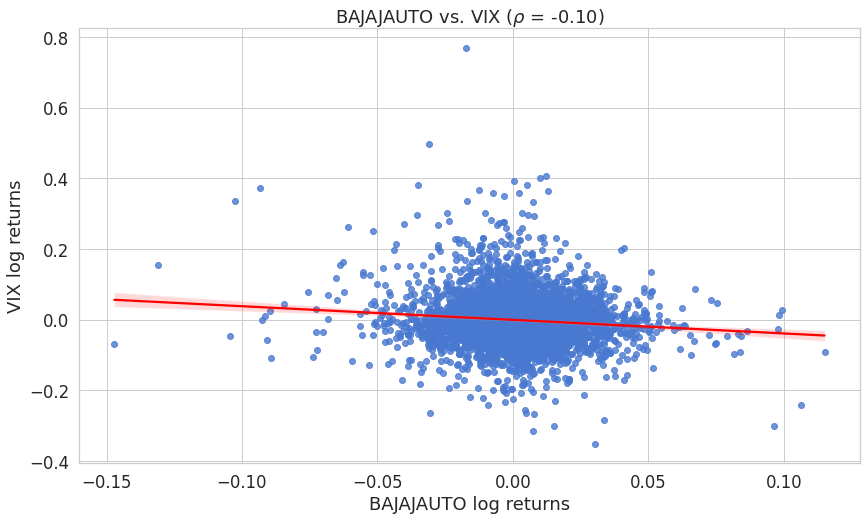

In [ ]:
ax = sns.regplot(x = 'log_rtn', y = 'vol_rtn', data = df, line_kws = {'color': 'red'})
ax.set(title = f'BAJAJAUTO vs. VIX ($\\rho$ = {corr_coeff:.2f})', ylabel = 'VIX log returns', xlabel = 'BAJAJAUTO log returns')

In [ ]:
r_range = np.linspace(min(df.log_rtn), max(df.log_rtn), num = 1000)
mu = df.log_rtn.mean()
sigma = df.log_rtn.std()
norm_pdf = scs.norm.pdf(r_range, loc = mu, scale = sigma)

**If the two distributions which we are comparing are exactly equal then the points on the Q-Q plot will perfectly lie on a straight line y = x.
If the points at the ends of the curve formed from the points are not falling on a straight line but indeed are scattered significantly from the positions then we cannot conclude a relationship between the x and y axes which clearly signifies that our ordered values which we wanted to calculate are not Normally distributed.**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Q-Q plot')

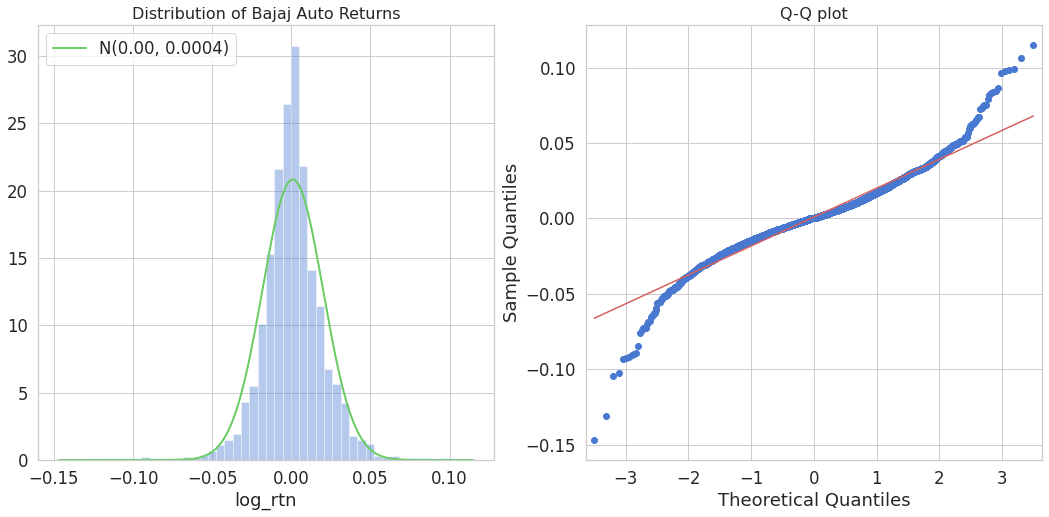

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (18, 8))

#historgram
sns.distplot(df.log_rtn, kde = False, norm_hist = True, ax = ax[0])
ax[0].set_title('Distribution of Bajaj Auto Returns', fontsize = 16)
ax[0].plot(r_range, norm_pdf, 'g', lw = 2, label = f'N({mu:.2f}, {sigma**2:.4f})')
ax[0].legend(loc = 'best')

#Q-Q plot
qq = sm.qqplot(df.log_rtn.values, line = 's', ax = ax[1])
ax[1].set_title('Q-Q plot', fontsize = 16)

[Text(0, 0.5, 'Absolute Returns'), Text(0.5, 0, 'Lag')]

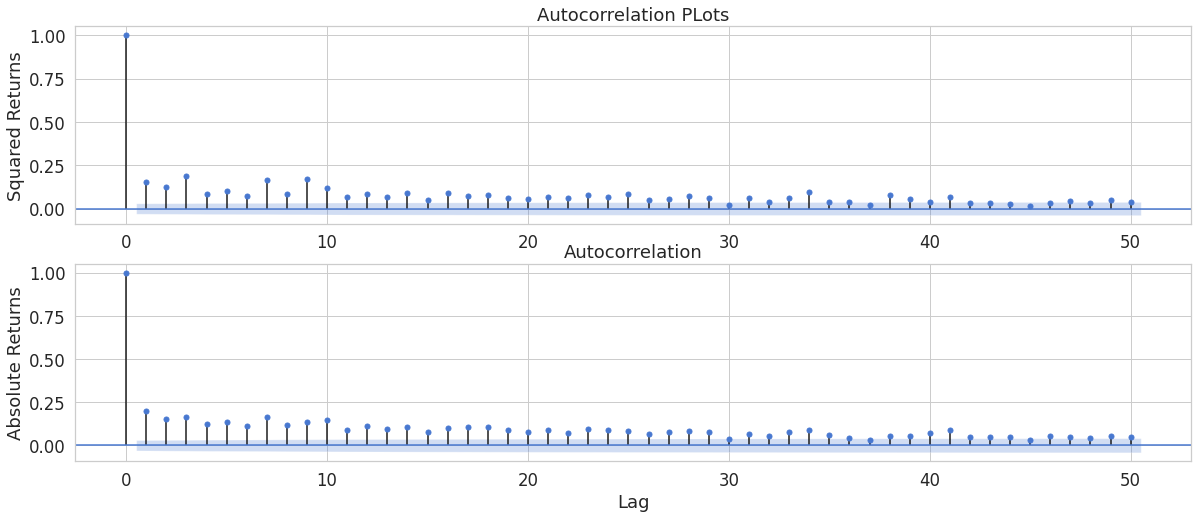

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (20, 8))
smt.graphics.plot_acf(df.log_rtn ** 2, lags = 50, alpha = 0.05, ax = ax[0])
ax[0].set(title = 'Autocorrelation PLots', ylabel = 'Squared Returns')
smt.graphics.plot_acf(np.abs(df.log_rtn), lags = 50, alpha = 0.05, ax = ax[1])
ax[1].set(ylabel = 'Absolute Returns', xlabel = 'Lag')

In [ ]:
df['moving_std_252'] = df[['log_rtn']].rolling(window = 252).std()
df['moving_std_21'] = df[['log_rtn']].rolling(window = 21).std()

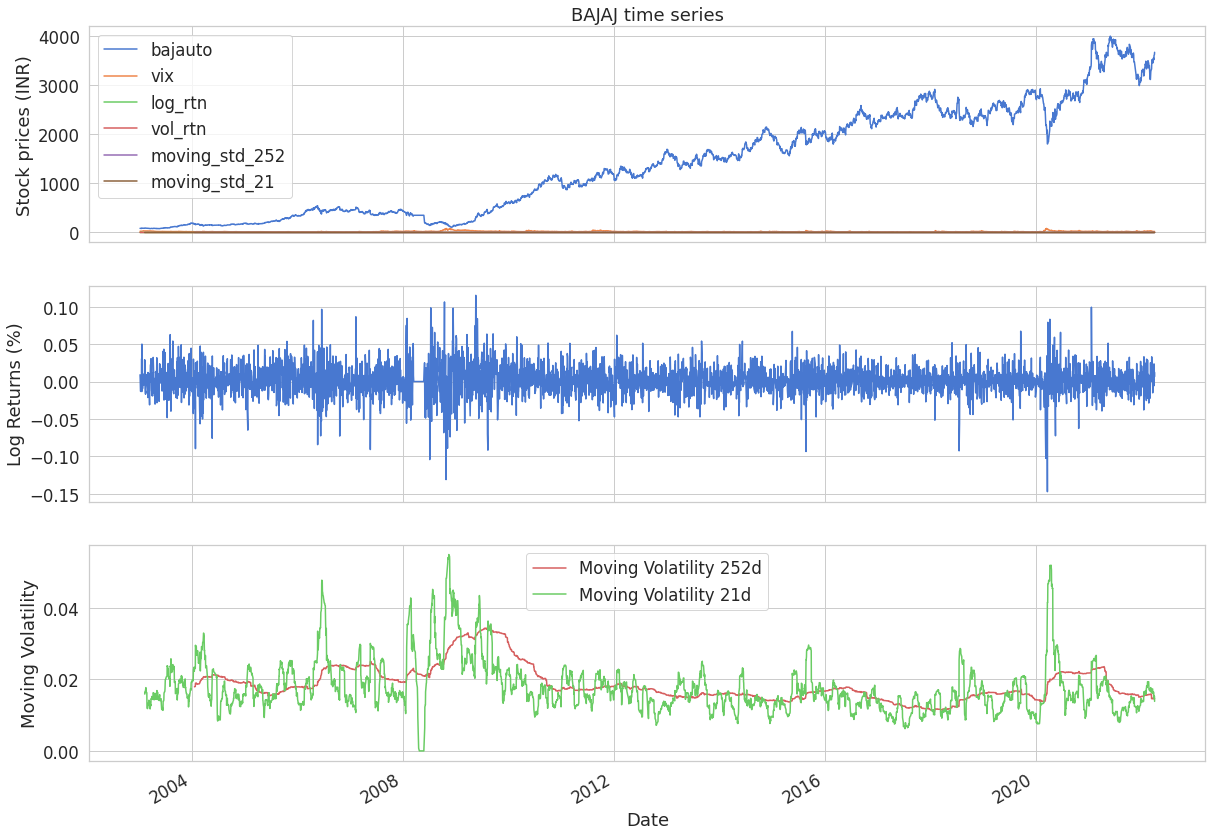

In [ ]:
fig, ax = plt.subplots(3, 1, figsize = (20, 15), sharex = True)
df.plot(ax = ax[0])
ax[0].set(title = 'BAJAJ time series', ylabel = 'Stock prices (INR)')
df.log_rtn.plot(ax = ax[1])
ax[1].set(ylabel = 'Log Returns (%)')
df.moving_std_252.plot(ax = ax[2], color = 'r', label = 'Moving Volatility 252d')
df.moving_std_21.plot(ax = ax[2], color = 'g', label = 'Moving Volatility 21d')
ax[2].set(ylabel = 'Moving Volatility', xlabel = 'Date')
ax[2].legend()

In [ ]:
df = yf.download('BAJAJ-AUTO.NS', start = '2003-01-01', end = '2022-07-06', progress = True)

[*********************100%***********************]  1 of 1 completed


In [ ]:
df.reset_index(drop = False, inplace = True)
df.rename(columns = {'Date': 'ds', 'Adj Close': 'y'}, inplace = True)

In [ ]:
df

,ds,Open,High,Low,Close,y,Volume
0,2003-01-01,125.500000,127.987503,125.250000,127.187500,84.865875,225530
1,2003-01-02,127.500000,127.875000,125.287498,125.612503,83.814972,151960
2,2003-01-03,125.750000,127.750000,123.750000,126.750000,84.573967,316950
3,2003-01-06,127.500000,127.500000,124.775002,125.437500,83.698204,282782
4,2003-01-07,127.425003,127.425003,123.262497,123.787498,82.597229,178276
...,...,...,...,...,...,...,...
4839,2022-06-29,3880.000000,3900.000000,3856.050049,3867.550049,3727.550049,524392
4840,2022-06-30,3750.000000,3768.350098,3692.000000,3706.600098,3706.600098,715926
4841,2022-07-01,3667.949951,3678.699951,3601.100098,3624.600098,3624.600098,756589
4842,2022-07-04,3644.399902,3695.149902,3608.000000,3679.750000,3679.750000,536505


In [ ]:
train_indices = df.ds.apply(lambda x: x.year) < 2022
df_train = df.loc[train_indices].dropna()
df_test = df.loc[~train_indices].reset_index(drop = True)

**Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.**

In [ ]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from datetime import date
from statsmodels.tsa.holtwinters import (ExponentialSmoothing, SimpleExpSmoothing, Holt)
from fbprophet import Prophet

In [ ]:
model_prophet = Prophet(seasonality_mode = 'additive', daily_seasonality = True)
model_prophet.add_seasonality(name = 'monthly', period = 30.5, fourier_order = 5)

In [ ]:
model_prophet.fit(df_train)

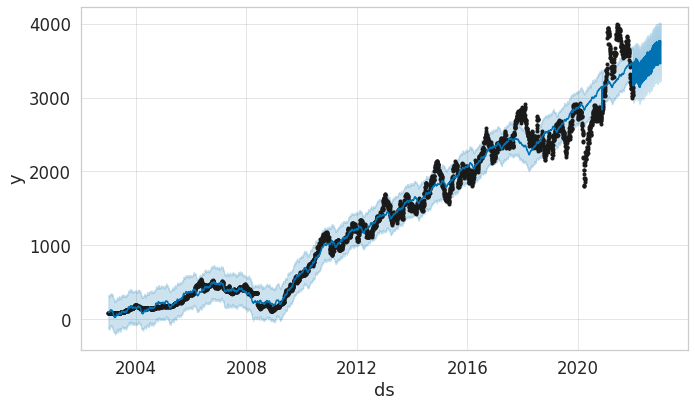

In [ ]:
df_future = model_prophet.make_future_dataframe(periods = 365)
df_pred = model_prophet.predict(df_future)
model_prophet.plot(df_pred);

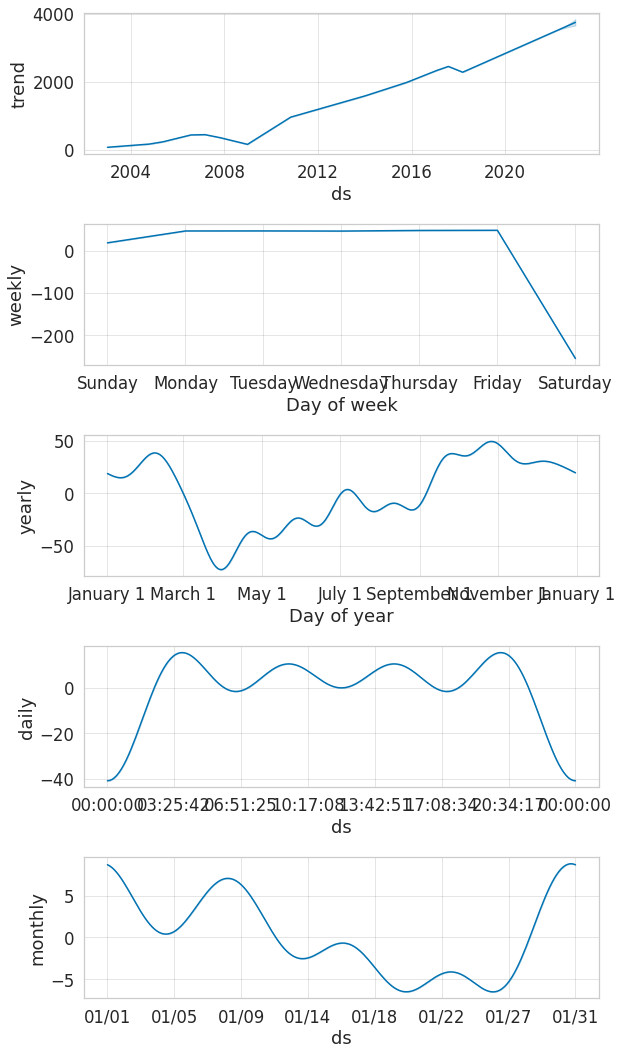

In [ ]:
model_prophet.plot_components(df_pred);

# **LSTM**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/bajaj-2003-2020.xls')

In [ ]:
df.isnull().sum()

Symbol                   0
Series                   0
Date                     0
Prev Close               0
Open Price               0
High Price               0
Low Price                0
Last Price               0
Close Price              0
Average Price            0
Total Traded Quantity    0
Turnover                 0
No. of Trades            0
dtype: int64

In [ ]:
df.columns

Index(['Symbol', 'Series', 'Date', 'Prev Close', 'Open Price', 'High Price',
       'Low Price', 'Last Price', 'Close Price', 'Average Price',
       'Total Traded Quantity', 'Turnover', 'No. of Trades'],
      dtype='object')

In [ ]:
df.head(4)

,Symbol,Series,Date,Prev Close,Open Price,High Price,Low Price,Last Price,Close Price,Average Price,Total Traded Quantity,Turnover,No. of Trades
0,BAJAUTOFIN,EQ,01-Jan-2003,48.10,49.5,49.50,48.5,49.0,49.00,49.14,3595,176665.00,-
1,BAJAUTOFIN,EQ,02-Jan-2003,49.00,49.0,49.25,49.0,49.0,49.00,49.04,1975,96852.50,-
2,BAJAUTOFIN,EQ,03-Jan-2003,49.00,48.0,49.25,48.0,49.1,49.15,48.83,761,37158.75,-
3,BAJAUTOFIN,EQ,06-Jan-2003,49.15,46.0,48.75,46.0,48.5,48.55,48.27,809,39054.25,-


In [ ]:
df.set_index("Date", inplace = True)
df.index = pd.to_datetime(df.index)
df.head(4)

,Symbol,Series,Prev Close,Open Price,High Price,Low Price,Last Price,Close Price,Average Price,Total Traded Quantity,Turnover,No. of Trades
Date,,,,,,,,,,,,
2003-01-01,BAJAUTOFIN,EQ,48.10,49.5,49.50,48.5,49.0,49.00,49.14,3595,176665.00,-
2003-01-02,BAJAUTOFIN,EQ,49.00,49.0,49.25,49.0,49.0,49.00,49.04,1975,96852.50,-
2003-01-03,BAJAUTOFIN,EQ,49.00,48.0,49.25,48.0,49.1,49.15,48.83,761,37158.75,-
2003-01-06,BAJAUTOFIN,EQ,49.15,46.0,48.75,46.0,48.5,48.55,48.27,809,39054.25,-


In [ ]:
df.shape

(4388, 12)

In [ ]:
print(df["Series"].unique())

['EQ' 'N1' 'W1' 'BL']


#### We will consider only equity stocks in Series column

In [ ]:
temp_df = df[df['Symbol'] == 'BAJFINANCE']
new_df = temp_df[temp_df['Series'] == 'EQ']
new_df.head()

,Symbol,Series,Prev Close,Open Price,High Price,Low Price,Last Price,Close Price,Average Price,Total Traded Quantity,Turnover,No. of Trades
Date,,,,,,,,,,,,
2010-09-29,BAJFINANCE,EQ,793.60,780.0,805.00,770.00,776.00,774.60,783.42,26000,20369029.10,-
2010-09-30,BAJFINANCE,EQ,774.60,775.0,783.45,766.25,772.00,773.55,774.33,17350,13434686.25,-
2010-10-01,BAJFINANCE,EQ,773.55,763.0,797.30,760.25,773.60,774.95,780.22,35941,28041955.80,-
2010-10-04,BAJFINANCE,EQ,774.95,788.0,795.00,775.00,786.65,783.40,786.88,31160,24519305.25,-
2010-10-05,BAJFINANCE,EQ,783.40,775.1,788.00,772.05,778.95,779.00,778.79,32141,25031172.60,-


In [ ]:
new_df.shape

(2433, 12)

In [ ]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

In [ ]:
new_df.drop(['Symbol', 'Series', 'No. of Trades'], axis = 1, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
new_df.head(4)

,Prev Close,Open Price,High Price,Low Price,Last Price,Close Price,Average Price,Total Traded Quantity,Turnover
Date,,,,,,,,,
2010-09-29,793.60,780.0,805.00,770.00,776.00,774.60,783.42,26000,20369029.10
2010-09-30,774.60,775.0,783.45,766.25,772.00,773.55,774.33,17350,13434686.25
2010-10-01,773.55,763.0,797.30,760.25,773.60,774.95,780.22,35941,28041955.80
2010-10-04,774.95,788.0,795.00,775.00,786.65,783.40,786.88,31160,24519305.25


In [ ]:
new_df.shape

(2433, 9)

In [ ]:
x = new_df[['Prev Close', 'Open Price', 'High Price', 'Low Price', 'Last Price', 'Average Price',
            'Total Traded Quantity', 'Turnover']].copy()
y = new_df['Close Price'].copy()

x[['Prev Close', 'Open Price', 'High Price', 'Low Price', 'Last Price', 'Average Price',
   'Total Traded Quantity', 'Turnover']] = x_scaler.fit_transform(x)
y = y_scaler.fit_transform(y.values.reshape(-1, 1))

In [ ]:
def load_data(X, seq_len, train_size=0.9):
    amount_of_features = X.shape[1]
    X_mat = X.values
    sequence_length = seq_len + 1
    data = []
    
    for index in range(len(X_mat) - sequence_length):
        data.append(X_mat[index: index + sequence_length])
    
    data = np.array(data)
    train_split = int(round(train_size * data.shape[0]))
    train_data = data[:train_split, :]
    
    x_train = train_data[:, :-1]
    y_train = train_data[:, -1][:,-1]
    
    x_test = data[train_split:, :-1] 
    y_test = data[train_split:, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return x_train, y_train, x_test, y_test

In [ ]:
window = 22
x['close'] = y
X_train, y_train, X_test, y_test = load_data(x, window)

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print(X_train[0], y_train[0])

(2169, 22, 9) (2169,) (241, 22, 9) (241,)
[[2.29700707e-02 2.04841713e-02 2.08072870e-02 2.17512549e-02
  2.21048703e-02 2.11757070e-02 9.97573113e-04 2.30773728e-04
  2.12187411e-02]
 [2.12187411e-02 2.00186220e-02 1.88828362e-02 2.14026771e-02
  2.17362254e-02 2.03447314e-02 6.64368208e-04 1.51866445e-04
  2.11219571e-02]
 [2.11219571e-02 1.89013035e-02 2.01196642e-02 2.08449526e-02
  2.18836833e-02 2.08831743e-02 1.38050837e-03 3.18085506e-04
  2.12510024e-02]
 [2.12510024e-02 2.12290503e-02 1.99142704e-02 2.22160253e-02
  2.30863873e-02 2.14920079e-02 1.19634043e-03 2.78000556e-04
  2.20298832e-02]
 [2.20298832e-02 2.00279330e-02 1.92891588e-02 2.19418107e-02
  2.23767459e-02 2.07524488e-02 1.23412933e-03 2.83825198e-04
  2.16243121e-02]
 [2.16243121e-02 2.34636872e-02 2.14323986e-02 2.20301171e-02
  2.43121316e-02 2.24143999e-02 2.66078562e-03 6.26350597e-04
  2.35092959e-02]
 [2.35092959e-02 2.15083799e-02 2.09858903e-02 2.25134783e-02
  2.31094276e-02 2.23577217e-02 1.46340513e-

In [ ]:
new_df.shape

(2433, 9)

In [ ]:
def build_model(input_shape):
    d = 0.2
    model = Sequential()
    
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(128, input_shape=input_shape, return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
model = build_model(input_shape = (window, 9))

In [ ]:
model.fit(X_train, y_train, batch_size = 32, epochs = 50, verbose = 1)

Epoch 1/50
68/68 [==============================] - 11s 164ms/step - loss: 0.0011 - accuracy: 9.2208e-04
Epoch 2/50
68/68 [==============================] - 13s 190ms/step - loss: 0.0013 - accuracy: 9.2208e-04
Epoch 3/50
68/68 [==============================] - 13s 194ms/step - loss: 9.6099e-04 - accuracy: 9.2208e-04
Epoch 4/50
68/68 [==============================] - 12s 181ms/step - loss: 9.8163e-04 - accuracy: 9.2208e-04
Epoch 5/50
68/68 [==============================] - 12s 183ms/step - loss: 9.3162e-04 - accuracy: 9.2208e-04
Epoch 6/50
68/68 [==============================] - 9s 136ms/step - loss: 9.9660e-04 - accuracy: 9.2208e-04
Epoch 7/50
68/68 [==============================] - 7s 109ms/step - loss: 9.0343e-04 - accuracy: 9.2208e-04
Epoch 8/50
68/68 [==============================] - 9s 137ms/step - loss: 8.0344e-04 - accuracy: 9.2208e-04
Epoch 9/50
68/68 [==============================] - 10s 147ms/step - loss: 8.3774e-04 - accuracy: 9.2208e-04
Epoch 10/50
68/68 [===========

In [ ]:
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

In [ ]:
print("TrainPredict shape", trainPredict.shape)
print("TestPredict shape", testPredict.shape)

TrainPredict shape (2169, 1)
TestPredict shape (241, 1)


In [ ]:
trainPredict = y_scaler.inverse_transform(trainPredict)
trainY = y_scaler.inverse_transform([y_train])

In [ ]:
testPredict = y_scaler.inverse_transform(testPredict)
testY = y_scaler.inverse_transform([y_test])

In [ ]:
plot_predicted = testPredict.copy()
plot_predicted = plot_predicted.reshape(241, 1)

In [ ]:
plot_actual = testY.copy()
plot_actual = plot_actual.reshape(241, 1)

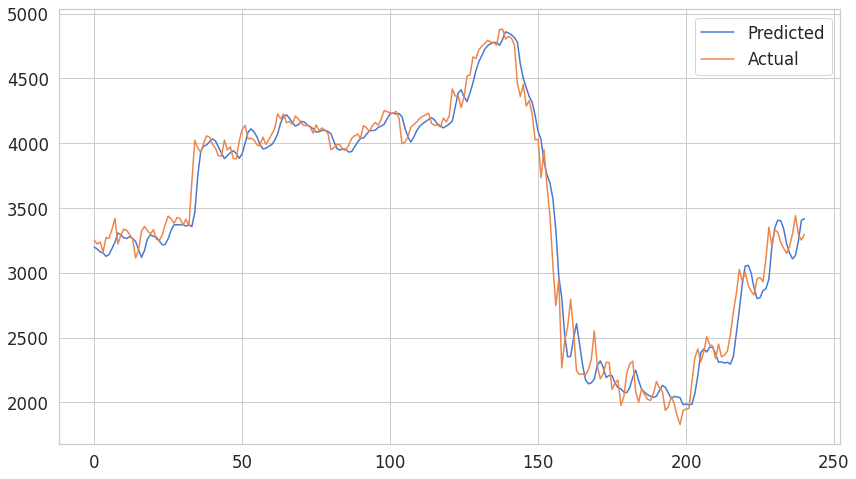

In [ ]:
plt.plot(pd.DataFrame(plot_predicted), label = 'Predicted')
plt.plot(pd.DataFrame(plot_actual), label = 'Actual')
plt.legend(loc = 'best')
plt.show()

In [ ]:
trainScore = metrics.mean_squared_error(trainY[0], trainPredict[:, 0]) ** 0.5
print('Train Score: %.2f RMSE' % trainScore)

Train Score: 232.25 RMSE


In [ ]:
testScore = metrics.mean_squared_error(testY[0], testPredict[:, 0]) ** 0.5
print('Test Score: %.2f RMSE' % testScore) 

Test Score: 141.08 RMSE


In [ ]:
new_df.columns

Index(['Prev Close', 'Open Price', 'High Price', 'Low Price', 'Last Price',
       'Close Price', 'Average Price', 'Total Traded Quantity', 'Turnover'],
      dtype='object')

In [ ]:
df.set_index("Date", inplace = True)
df.index = pd.to_datetime(df.index)
temp_df = df[df['Symbol'] == 'BAJFINANCE']
new_df = temp_df[temp_df['Series'] == 'EQ']

In [ ]:
new_df.head()

,Symbol,Series,Prev Close,Open Price,High Price,Low Price,Last Price,Close Price,Average Price,Total Traded Quantity,Turnover,No. of Trades
Date,,,,,,,,,,,,
2010-09-29,BAJFINANCE,EQ,793.60,780.0,805.00,770.00,776.00,774.60,783.42,26000,20369029.10,-
2010-09-30,BAJFINANCE,EQ,774.60,775.0,783.45,766.25,772.00,773.55,774.33,17350,13434686.25,-
2010-10-01,BAJFINANCE,EQ,773.55,763.0,797.30,760.25,773.60,774.95,780.22,35941,28041955.80,-
2010-10-04,BAJFINANCE,EQ,774.95,788.0,795.00,775.00,786.65,783.40,786.88,31160,24519305.25,-
2010-10-05,BAJFINANCE,EQ,783.40,775.1,788.00,772.05,778.95,779.00,778.79,32141,25031172.60,-


In [ ]:
new_df.columns

Index(['Symbol', 'Series', 'Prev Close', 'Open Price', 'High Price',
       'Low Price', 'Last Price', 'Close Price', 'Average Price',
       'Total Traded Quantity', 'Turnover', 'No. of Trades'],
      dtype='object')

In [ ]:
prices = new_df['Close Price'].values.astype('float32')
prices = prices.reshape(len(prices), 1)

In [ ]:
trainPredictPlot = np.empty_like(prices)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[window: len(trainPredict) + window, :] = trainPredict

In [ ]:
testPredictPlot = np.empty_like(prices)
testPredictPlot[:, :] = np.nan
testPredictPlot[(len(prices) - testPredict.shape[0]): len(prices), :] = testPredict

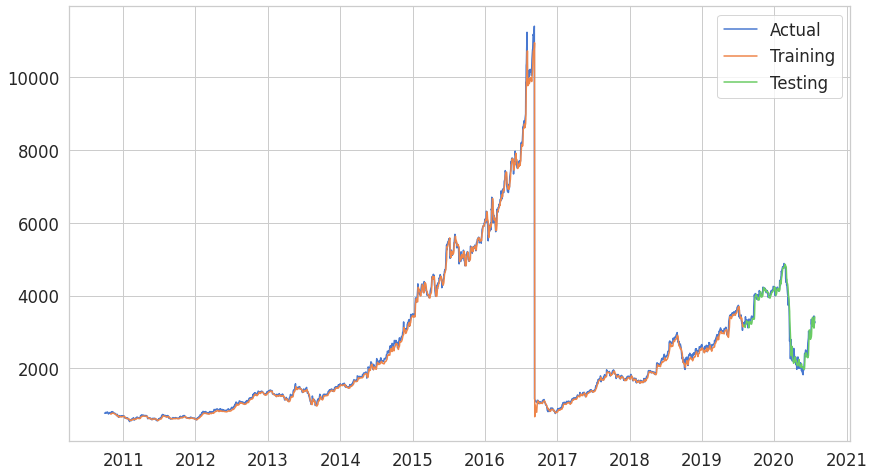

In [ ]:
plt.plot(pd.DataFrame(prices, columns = ['close'], index = new_df.index).close, label = 'Actual')
plt.plot(pd.DataFrame(trainPredictPlot, columns = ['close'], index = new_df.index).close, label = 'Training')
plt.plot(pd.DataFrame(testPredictPlot, columns = ["close"], index = new_df.index).close, label = 'Testing')
plt.legend(loc = 'best')
plt.show()

# **ARIMA**

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import lag_plot
import warnings
warnings.filterwarnings('ignore')

In [ ]:
bajaj = yf.download('BAJAJ-AUTO.NS', start = '2003-01-01', end = '2022-07-06', progress = False)

In [ ]:
bajaj.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2003-01-01,125.500000,127.987503,125.250000,127.187500,84.865891,225530
2003-01-02,127.500000,127.875000,125.287498,125.612503,83.814972,151960
2003-01-03,125.750000,127.750000,123.750000,126.750000,84.573975,316950
2003-01-06,127.500000,127.500000,124.775002,125.437500,83.698204,282782
2003-01-07,127.425003,127.425003,123.262497,123.787498,82.597229,178276


In [ ]:
print(bajaj.head())
print(bajaj.shape)
print(bajaj.columns)

                  Open        High         Low       Close  Adj Close  Volume
Date                                                                         
2003-01-01  125.500000  127.987503  125.250000  127.187500  84.865891  225530
2003-01-02  127.500000  127.875000  125.287498  125.612503  83.814972  151960
2003-01-03  125.750000  127.750000  123.750000  126.750000  84.573975  316950
2003-01-06  127.500000  127.500000  124.775002  125.437500  83.698204  282782
2003-01-07  127.425003  127.425003  123.262497  123.787498  82.597229  178276
(4844, 6)
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


In [ ]:
bajaj.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-06-29,3880.000000,3900.000000,3856.050049,3867.550049,3727.550049,524392
2022-06-30,3750.000000,3768.350098,3692.000000,3706.600098,3706.600098,715926
2022-07-01,3667.949951,3678.699951,3601.100098,3624.600098,3624.600098,756589
2022-07-04,3644.399902,3695.149902,3608.000000,3679.750000,3679.750000,536505
2022-07-05,3700.000000,3700.000000,3663.000000,3682.750000,3682.750000,294980


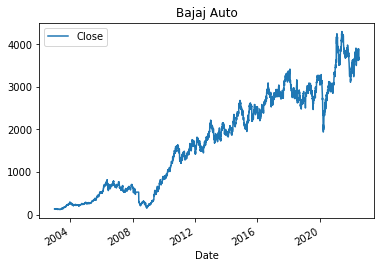

In [ ]:
bajaj[['Close']].plot()
plt.title("Bajaj Auto")
plt.show()

Text(0.5, 1.0, 'Bajaj Auto Cumulative Returns')

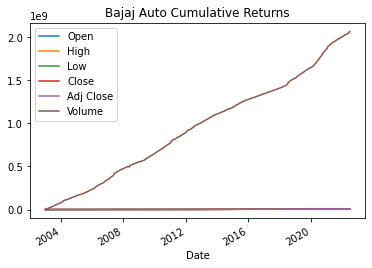

In [ ]:
#Cumulative Returns
dr = bajaj.cumsum()
dr.plot()
plt.title("Bajaj Auto Cumulative Returns")

**Lag plots are most commonly used to look for patterns in time series data. A lag plot is a special type of scatter plot in which the X-axis represents the dataset with some time units behind or ahead as compared to the Y-axis. If the lag plot gives a linear plot, then it means the autocorrelation is present in the data. Autocorrelation refers to the degree of correlation of the same variables between two successive time intervals. It measures how the lagged version of the value of a variable is related to the original version of it in a time series.**

Text(0.5, 1.0, 'Bajaj Auto Autocorrelation plot')

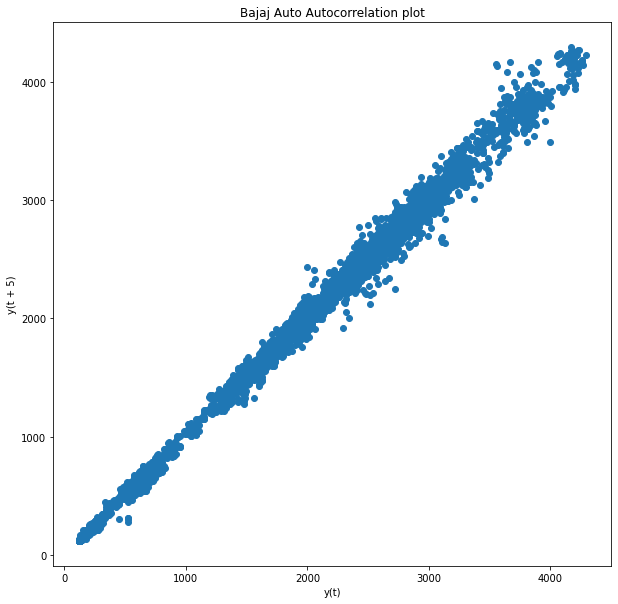

In [ ]:
plt.figure(figsize = (10, 10))
lag_plot(bajaj['Open'], lag = 5)
plt.title('Bajaj Auto Autocorrelation plot')

In [ ]:
bajaj.reset_index(level=0, inplace=True)
bajaj.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2003-01-01,125.500000,127.987503,125.250000,127.187500,84.865891,225530
1,2003-01-02,127.500000,127.875000,125.287498,125.612503,83.814972,151960
2,2003-01-03,125.750000,127.750000,123.750000,126.750000,84.573975,316950
3,2003-01-06,127.500000,127.500000,124.775002,125.437500,83.698204,282782
4,2003-01-07,127.425003,127.425003,123.262497,123.787498,82.597229,178276


([<matplotlib.axis.XTick at 0x7f7657b1f0d0>,
 [Text(0, 0, '2003-01-01 00:00:00'),
  Text(0, 0, '2004-02-25 00:00:00'),
  Text(0, 0, '2005-04-26 00:00:00'),
  Text(0, 0, '2006-07-10 00:00:00'),
  Text(0, 0, '2007-09-21 00:00:00'),
  Text(0, 0, '2008-12-11 00:00:00'),
  Text(0, 0, '2010-03-09 00:00:00'),
  Text(0, 0, '2011-05-19 00:00:00'),
  Text(0, 0, '2012-08-02 00:00:00'),
  Text(0, 0, '2013-10-24 00:00:00'),
  Text(0, 0, '2015-01-15 00:00:00'),
  Text(0, 0, '2016-04-06 00:00:00'),
  Text(0, 0, '2017-06-23 00:00:00'),
  Text(0, 0, '2018-09-06 00:00:00'),
  Text(0, 0, '2019-12-04 00:00:00'),
  Text(0, 0, '2021-02-15 00:00:00'),
  Text(0, 0, '2022-05-05 00:00:00')])

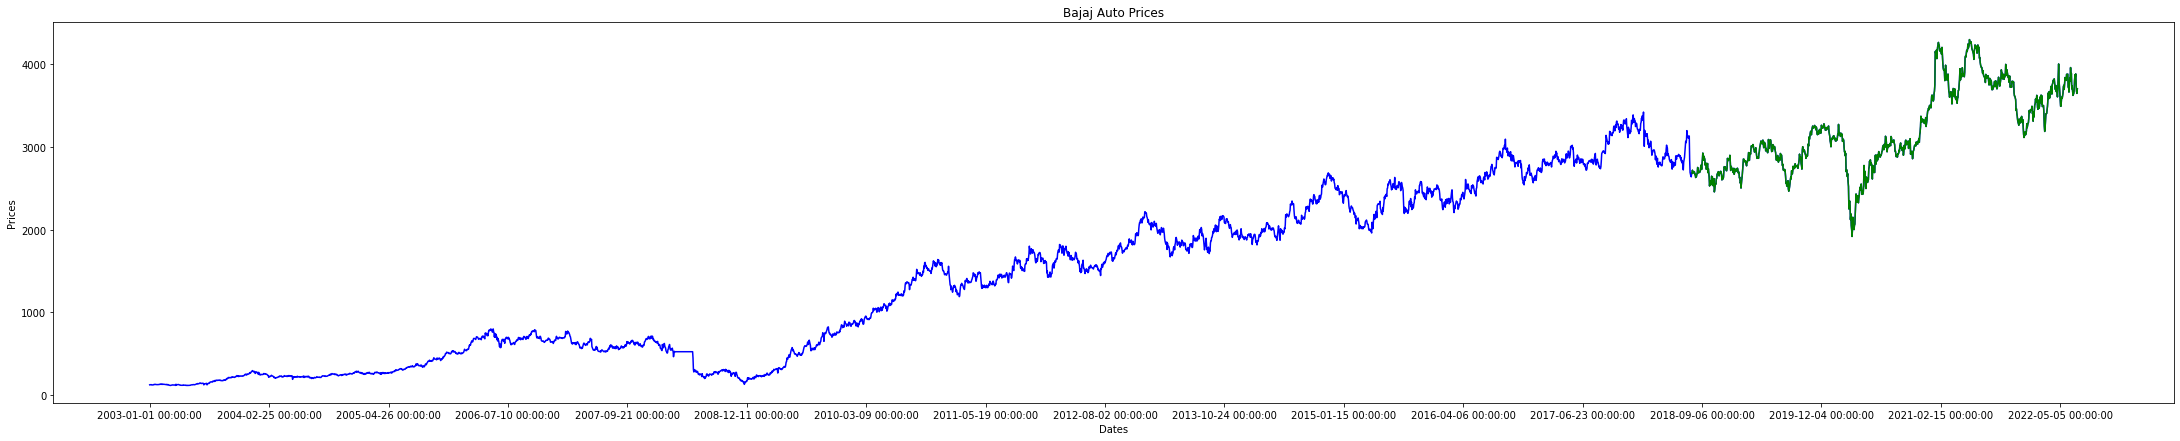

In [ ]:
train_data, test_data = bajaj[0:int(len(bajaj) * 0.8)], bajaj[int(len(bajaj) * 0.8):]
plt.figure(figsize = (38, 7))
plt.title('Bajaj Auto Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(bajaj['Open'], 'blue', label = 'Training Data')
plt.plot(test_data['Open'], 'green', label = 'Testing Data')
plt.xticks(np.arange(0, 4843, 300), bajaj['Date'][0:4843:300])

In [ ]:
#symmetric mean absolute percentage error
def smape_kun(y_true, y_pred):
  return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))

In [ ]:
train_arima = train_data['Open'].values
test_arima = test_data['Open'].values

In [ ]:
history = [x for x in train_arima]
print(type(history))
predictions = list()
for t in range(len(test_arima)):
  model = ARIMA(history, order = (5, 1, 0))
  model_fit = model.fit(disp = 0)
  output = model_fit.forecast()
  yhat = output[0]
  predictions.append(yhat)
  obs = test_arima[t]
  history.append(obs)

<class 'list'>


In [ ]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(test_arima, predictions)
print('Testing Mean Squared Error: %.3f'%error)
error2 = smape_kun(test_arima, predictions)
print('Symmetric mean absolute error: %.3f'%error2)

Testing Mean Squared Error: 3188.584
Symmetric mean absolute error: 17.516


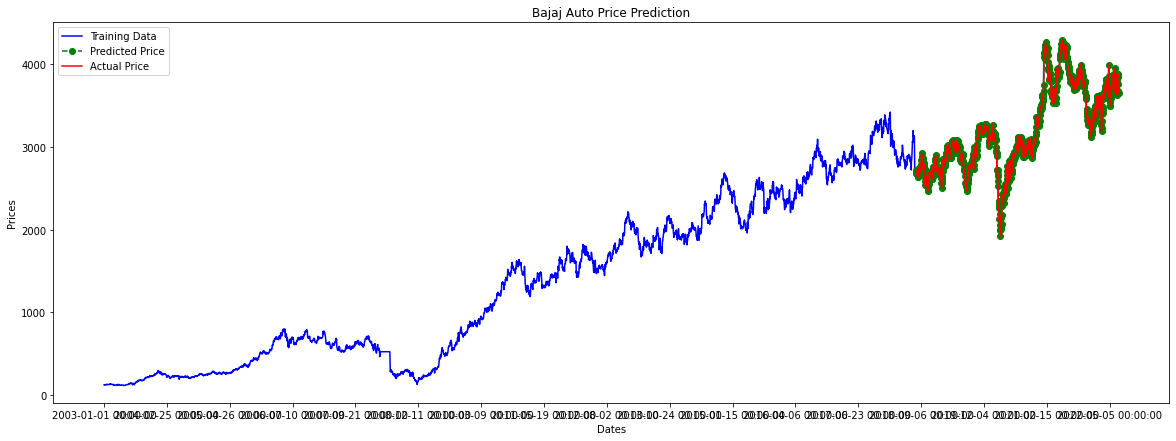

In [ ]:
plt.figure(figsize = (20, 7))
plt.plot(bajaj['Open'], 'green', color = 'blue', label = 'Training Data')
plt.plot(test_data.index, predictions, color = 'green', marker = 'o', linestyle = 'dashed', label = 'Predicted Price')
plt.plot(test_data.index, test_data['Open'], color = 'red', label = 'Actual Price')
plt.title('Bajaj Auto Price Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.xticks(np.arange(0,4843, 300), bajaj['Date'][0:4843:300])
plt.legend()

NameError: ignored

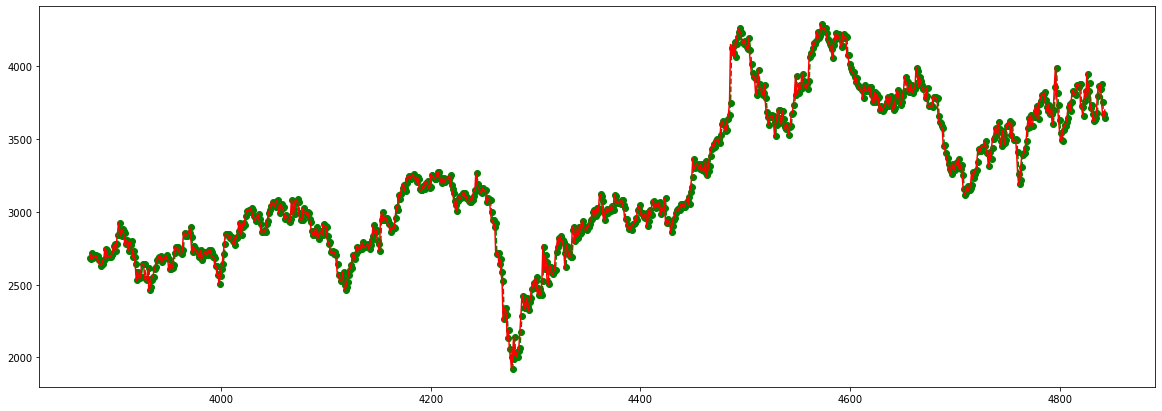

In [ ]:
plt.figure(figsize = (20, 7))
plt.plot(test_data.index, predictions, color = 'green', marker = 'o', linestyle = 'dashed', label = 'Predicted Price')
plt.plot(test_data.index, test_data['Open'], color = 'red', label = 'Actual Price')
plt.xticks(np.arange(1486,4842, 60), df['Date'][1486:4842:60])
plt.title('Bajaj Auto Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()

## **Visualization**

In [1]:
pip install dash

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.8 MB 6.1 MB/s 
     |████████████████████████████████| 357 kB 54.4 MB/s 


In [1]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.2 MB/s 
     |████████████████████████████████| 6.4 MB 11.9 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.28.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
%matplotlib inline
from pandas_datareader.data import DataReader
import yfinance as yf
from datetime import datetime

In [5]:
tech_list = ['BAJAJ-AUTO.NS']
end = datetime.now()
start = datetime(2003, 1, 1)
for stock in tech_list:
  globals()[stock] = yf.download(stock, start, end)

[*********************100%***********************]  1 of 1 completed


In [20]:
df = globals()['BAJAJ-AUTO.NS']

In [26]:
fig = px.area(df, x = df.index, y = 'Close', template = 'plotly_dark')
fig.show()

In [27]:
fig = px.area(df, x = df.index, y = 'Volume', template = 'plotly_dark')
fig.show()

**Daily Return**

In [43]:
df['Daily_Return'] = df['Adj Close'].pct_change()

In [44]:
fig = px.area(df, x = df.index, y = 'Daily_Return', template = 'plotly_dark')
fig.show()

In [45]:
fig = px.histogram(df, x = df.index, y = 'Daily_Return', template = 'plotly_dark')
fig.show()

In [51]:
closing_df = df['Adj Close']
closing_df.head()

Date
2003-01-01    84.865898
2003-01-02    83.814964
2003-01-03    84.573967
2003-01-06    83.698189
2003-01-07    82.597252
Name: Adj Close, dtype: float64

In [52]:
daily = closing_df.pct_change()
daily.head()

Date
2003-01-01         NaN
2003-01-02   -0.012383
2003-01-03    0.009056
2003-01-06   -0.010355
2003-01-07   -0.013154
Name: Adj Close, dtype: float64

In [46]:
area = np.pi * 20

Text(0, 0.5, 'Risk')

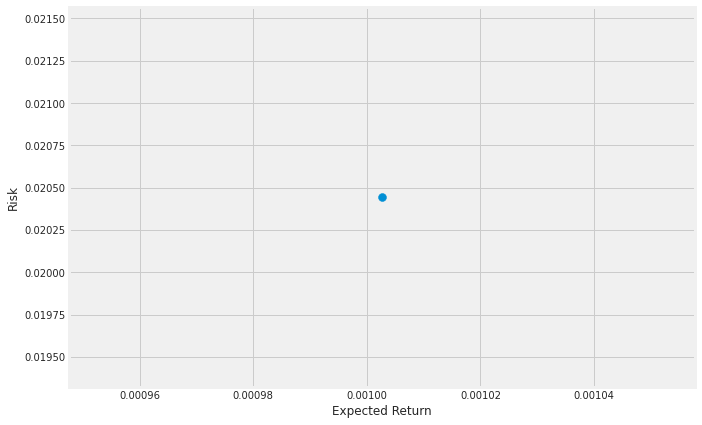

In [56]:
plt.figure(figsize = (10, 7))
plt.scatter(daily.mean(), daily.std(), s = area)
plt.xlabel('Expected Return')
plt.ylabel('Risk')

# **XGBoost Regressor**

In [3]:
bajaj = yf.download('BAJAJ-AUTO.NS', start = '2003-01-01', end = '2022-07-06', progress = False)

In [4]:
bajaj.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-06-29,3880.000000,3900.000000,3856.050049,3867.550049,3727.550049,524392
2022-06-30,3750.000000,3768.350098,3692.000000,3706.600098,3706.600098,715926
2022-07-01,3667.949951,3678.699951,3601.100098,3624.600098,3624.600098,756589
2022-07-04,3644.399902,3695.149902,3608.000000,3679.750000,3679.750000,536505
2022-07-05,3700.000000,3700.000000,3663.000000,3682.750000,3682.750000,294980


**Imputation transformer for completing missing values. It replaces the NaN values with a specified placeholder. Transform uses a previously computed mean and std to autoscale the data.**

In [5]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer()
bajaj = bajaj[['Low', 'Open', 'Volume', 'High', 'Close', 'Adj Close']]
imputed_data = pd.DataFrame(imputer.fit_transform(bajaj))
imputed_data.columns = bajaj.columns
bajaj = imputed_data

In [6]:
bajaj.head()

,Low,Open,Volume,High,Close,Adj Close
0,125.250000,125.500000,225530.0,127.987503,127.187500,84.865891
1,125.287498,127.500000,151960.0,127.875000,125.612503,83.814980
2,123.750000,125.750000,316950.0,127.750000,126.750000,84.573982
3,124.775002,127.500000,282782.0,127.500000,125.437500,83.698204
4,123.262497,127.425003,178276.0,127.425003,123.787498,82.597244


In [9]:
from sklearn.model_selection import train_test_split
X = bajaj[['Low', 'Open', 'Volume', 'Close', 'Adj Close']]
y = bajaj.High

X_train, X_valid, y_train, y_valid = train_test_split(X, y)

In [10]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

In [11]:
model = XGBRegressor(n_estimators = 1000, learning_rate = 0.05)
model.fit(X_train,
          y_train,
          early_stopping_rounds = 5,
          eval_set = [(X_valid, y_valid)],
          verbose = False)

[10:09:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(learning_rate=0.05, n_estimators=1000)

In [12]:
pred = model.predict(X_valid)

In [13]:
print = ("Mena Absolute Error: "+ str(mean_absolute_error(pred, y_valid)))

In [14]:
real = []
for item in y_valid.iteritems():
  real.append(item[1])
compare = pd.DataFrame(data = {'Predictions':pred,
                               'Real':real
                               }
                       )
compare

,Predictions,Real
0,217.484680,217.250000
1,634.814880,631.250000
2,2833.416260,2827.550049
3,286.352966,288.500000
4,1629.094116,1631.000000
...,...,...
1206,1961.437500,1957.949951
1207,3455.046875,3445.500000
1208,264.107452,267.000000
1209,124.322327,122.750000
